# Dog breed classifier

<p>A simple application design is presented here, which includes the application of various CNN models. An image is input to the app. First, an algorithm is employed to detect presence of dog or human face in the image, each using a binary classification model for the respective detection. If either human face or dog is detected, a classification model is used to distinguish it among 133 dog breed classes. There's little to no data analysis work done to, for example, study the distribution of data or its quality across the different classes. The task has been to obtain the application deisgn and try to optimize its test accuracy to the breed classification. The numbers of data points used for training, fixed validaiton, and testing are about 6500, 700, and 700, respectively.</p>

<p>In the notebook, beside the main topic, a CNN trained from scratch is also presented in comparison with the VGG16-transfer-learned model used in the final design of the application. So, in all, I include the following task segments in this notebook: Import datasets, detect human faces with binary CNN classifier, detect dog with CNN, train a CNN from scratch to classify dog breeds, create a transfer-learned CNN to classify dog breeds, write app algorithm, and test the said algorithm with a few cases. For a fun bonus I tried to superpose dog ear-nose shapes over human faces where applicable (if an eye-detection model found eyes falling in any face zone detected by the human face -detection model). Other bonuses to assigned tasks added include support to potentially detect dog mutts and including data augmentation to enhance detection generalization given the limited number of originally available data points.</p>

<p>The notebook is produced following my submission of the project of the same name for the Deep learning nanodegree program of Udacity, my submission there completed 2021-1.</p>


In [1]:
# Imports
%matplotlib inline

import os
import time

import matplotlib.pyplot as plt
import matplotlib.gridspec
import matplotlib.transforms as mtrf

import PIL.ImageFile
from PIL import Image
from tqdm import tqdm
from glob import glob

import numpy as np
import cv2
import torch
from torchvision import datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms as trf
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [1]:

# load filenames for human and dog images
human_files = np.array ( glob ( "data/lfw/*/*" ) )
dog_files = np.array ( glob ( "data/dogimages/*/*/*" ) )

# print number of images in each dataset
print ( "There are {:d} total human images.".format ( len(human_files) ) )
print( "There are {:d} total dog images.".format ( len(dog_files) ) )


There are 13233 total human images.
There are 8351 total dog images.



### Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images. OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).

Before using any of the face detectors, it is standard procedure to convert the images to grayscale. The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter. In the above code, `faces` is a numpy array of detected faces, each row a detected face specifying the bounding box of the detected face ref. top-left (x,y,w,h).


Eyes:
[[ 89  91  34  34]
 [134 100  25  25]
 [ 84 214  25  25]
 [152 198  22  22]
 [ 60 202  43  43]]
Number of faces detected: 1
Decent eyes:
[89, 91, 34, 34]
[134, 100, 25, 25]


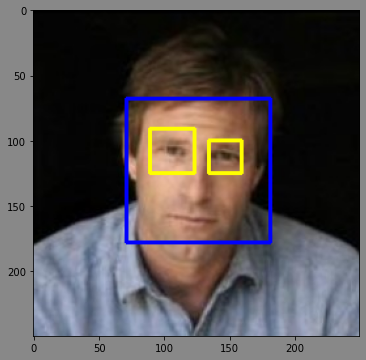

In [227]:

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier ( 'haarcascades/haarcascade_frontalface_alt.xml' )
eye_cascade = cv2.CascadeClassifier ( cv2.data.haarcascades + 'haarcascade_eye.xml' )   # Faraz-added

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)
eyes = eye_cascade.detectMultiScale(gray)   # Faraz-added
print ( "Eyes:\n{}".format(eyes) )   # Faraz-added

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
# Faraz-added
print ( "Decent eyes:" )
for eye in [ [89, 91, 34, 34], [134, 100, 25, 25] ]:
    print ( eye )   # Faraz-added
    (x,y,w,h) = eye
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)

# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
fig = plt.figure ( figsize=(6,6), facecolor="#888888" )   # Faraz-added
plt.imshow(cv_rgb)
plt.show()


In [280]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    eyes = eye_cascade.detectMultiScale(gray)   # Faraz-added: will use eyes to id/orientation position of ears
    # Faraz: to be robust, associate relevant eyes to each's face if multiple faces
    fceyes_d = {}
    for fc in faces:
        fceyes_d[tuple(fc)] = []
    #print (eyes)
    for eye in eyes:
        (x,y,w,h) = eye
        xctr, yctr = ( x+w/2, y+h/2 )
        for fc in fceyes_d.keys():
            fx,fy,fw,fh = fc
            # Faraz: ensure eye within face box
            #if x>fx-fw/10 and x+w<fx+fw and y>fy-fh/10 and y+h<fy+fh:
            if xctr>fx and yctr>fy and xctr<fx+fw and yctr<fy+fh and w<fw*0.7 and h<fh*0.7:
                fceyes_d[fc].append ( (xctr,yctr) )
    for fc in fceyes_d.keys():   # review face-eyes dict, being conservative, ensure exactly 2 eyes/face
        if len ( fceyes_d[fc] ) != 2:
            fceyes_d[fc] = []
    # Faraz note: I'll generally assume upright face between upright / upside-down
    return { "face_bool":len(faces)>0, "fceyes_d":fceyes_d }

#print ( * face_detector(human_files[0]).items(), sep="\n" )   # Faraz-added
print ( * face_detector('data/custom_test/0group1.jpg').items(), sep="\n" )   # Faraz-added


('face_bool', True)
('fceyes_d', {(285, 99, 115, 115): [(319.0, 145.0), (361.5, 139.5)], (74, 42, 133, 133): [], (399, 61, 127, 127): [(487.5, 109.5), (436.5, 108.5)], (182, 86, 116, 116): [(215.0, 129.0), (260.5, 133.5)]})


In [5]:
# Evaluae human face detection model

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

humhum_cnt = 0
doghum_cnt = 0

for humfp in human_files_short:
    if face_detector ( humfp )['face_bool']:
        humhum_cnt += 1
for dogfp in dog_files_short:
    if face_detector ( dogfp )['face_bool']:
        doghum_cnt += 1

humhum_tpr = humhum_cnt / len(human_files_short)
doghum_fpr = doghum_cnt / len(dog_files_short)

print ( "Percentages of human, dog data detected as human:" )
print ( "{:<20}{:>8.2f} %".format ( '"human"/human tpr:', 100.*humhum_tpr ) )
print ( "{:<20}{:>8.2f} %".format ( '"human"/dog fpr:', 100.*doghum_fpr ) )


Percentages of human, dog data detected as human:
"human"/human tpr:     96.00 %
"human"/dog fpr:       18.00 %


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](https://pytorch.org/vision/stable/models.html) to detect dogs in images, the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [6]:

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

In [7]:

NORM_MSS = ( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )
IMG_SZ0 = (224,224)

def VGG16_predict(img_path):
    """ Returns detected object class id given input image path """
    trf = transforms.Compose ( [
        transforms.Resize ( IMG_SZ0 ),
        transforms.ToTensor (),
        transforms.Normalize ( NORM_MSS[0], NORM_MSS[1] )
    ] )
    pil_img_rgb = Image.open ( img_path ).convert ( 'RGB' )
    #plt.imshow ( pil_img_rgb )
    #plt.show()
    # From Udacity style transfer exercise: discard the alpha channel (that's the :3) and add the batch dimension
    img = trf ( pil_img_rgb ) [:3,:,:].unsqueeze(0)
    #print ( img.shape )
    if use_cuda:
        img = img.cuda()
    logits = VGG16.forward ( img )
    _,clssi = logits.topk ( 1, dim=1 )
    return clssi.item()   # predicted class index

# Do a brief test:
print ( "\n\n{}\n  {}\n  {}\n".
       format ( "The model output is logits of the class nodes. I might as well take Softmax or such,",
       "but it wouldn't change the index of the max among the classes, so I have left them as",
       "logits and taken their max for index." ) )
for imgfp in human_files_short[:5]:
    print ( "human image -> {}".format ( VGG16_predict(imgfp) ) )
for imgfp in dog_files_short[:5]:
    print ( "dog image   -> {}".format ( VGG16_predict(imgfp) ) )




The model output is logits of the class nodes. I might as well take Softmax or such,
  but it wouldn't change the index of the max among the classes, so I have left them as
  logits and taken their max for index.

human image -> 841
human image -> 680
human image -> 490
human image -> 678
human image -> 400
dog image   -> 252
dog image   -> 252
dog image   -> 252
dog image   -> 252
dog image   -> 252


In [8]:
### returns "True" if a dog is detected in the image stored at img_path
DOG_CLASSES = tuple ( range ( 151,269 ) )
def dog_detector(img_path):
    ## TODO: Complete the function.
    return VGG16_predict ( img_path ) in DOG_CLASSES   # true/false
# Small test
# for imgfp in human_files_short[:5]:
#     print ( "human image -> {}".format ( dog_detector(imgfp) ) )
# for imgfp in dog_files_short[:5]:
#     print ( "dog image   -> {}".format ( dog_detector(imgfp) ) )


In [9]:
# Evaluate the dog_detector function on the images in human_files_short and dog_files_short.

humdog_cnt = 0
dogdog_cnt = 0

for humfp in human_files_short:
    if dog_detector ( humfp ):
        humdog_cnt += 1
    print ( ".",end="" )
print()
for dogfp in dog_files_short:
    if dog_detector ( dogfp ):
        dogdog_cnt += 1
    print ( ".",end="" )
print()

humdog_fpr = humdog_cnt / len(human_files_short)
dogdog_tpr = dogdog_cnt / len(dog_files_short)

print ( "Percentages of human, dog data detected as dog:" )
print ( "{:<20}{:>8.2f} %".format ( '"dog"/human fpr:', 100.*humdog_fpr ) )
print ( "{:<20}{:>8.2f} %".format ( '"dog"/dog tpr:', 100.*dogdog_tpr ) )


....................................................................................................
....................................................................................................
Percentages of human, dog data detected as dog:
"dog"/human fpr:        0.00 %
"dog"/dog tpr:         95.00 %


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images. In this step, you will create a CNN that classifies dog breeds. You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), having to attain a test accuracy of at least 10%. In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging. To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel. It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels). Likewise, recall that labradors come in yellow, chocolate, and black. Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.

Remember that the practice is far ahead of the theory in deep learning. Experiment with many different architectures, and trust your intuition. And, of course, have fun!

Data preprocessing comments:
- The image size I chose is a square of 128x128 for each channel of each image. I'd initially chosen 256x256 but after memory problems and training time, I reduced it to 128 per square edge. It's set to contain enough information for a model to reasonably be able to extract for distinguishing among dog breeds. The dimensions form a square of edge of power of two, a consideration for higher calculation efficiencies if done by GPUs, that and square also because of conformity with the CNN structure that will probably involve multiple x2 or x4 pool downscalings.
- I did augment the dataset using PyTorch's random transformation methods. Instead of increasing the static daaset size by adding more data, they randomly vary the data going through the respective loaders. It would be similar to training on an enlarged dataset to go through more epochs, e.g. x3 x4 of that intended aprior. The transforms I used include rotation (-30~30 degrees not lead to too unreasonable images), random horizontal flips (again not vertical), random resizing, random cropping, and a smaller fraction (probability) for transition to grayscale.

Model architecture:
- I part- educated guessingly and part- arbitrarily decided to go with a sequence of convolutional, max pooling, and fully connected layers. I decided to use alternating Conv and Pool layers for training time and memory efficiency. I further had to move the process to my local machine. The goal is to gain higher-level deeper information from the initially seemingly independent pixel distribution, and literally a deep and narrow array:
- An input of 3x128x128 goes through alternating Conv2d and MaxPool layers, dimensions of 16x128x128, 16x64x64, 32x64x64, 32x16x16, 64x16x16, 64x4x4; so we go from content of 49152 scalar units to 1024 at the end of the convolutional section, but from seemingly independent pixel-local info to high-level deep info. Then follow FC layers of 1024, 512, and 133 nodes (last layer corresponding to classification logits and might then pass through the softmax or like function normalizing their distribution against each other) for detection among 133 dog breeds. To avoid overfitting from possibly too much complexity I've applied regularization after every rely of the conv layer output before the next pooling layer.
- Naturally necessarily, the input of each subsequent layer shall be compatible with the output of the prior layer, considering all in the case of switching to the fully-connected layers at the end toward classification. Each of the layers except for the final and the pooling layers are affected/confined by relu non-linear and then dropout layers turning off weights for their upcoming nodes


['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier']

001.Affenpinscher
torch.Size([3, 300, 400])


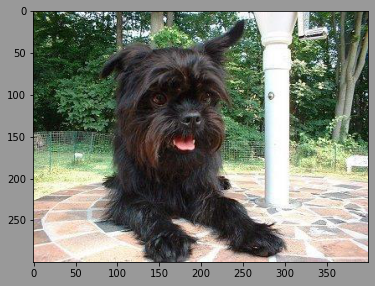


002.Afghan_hound
torch.Size([3, 768, 762])


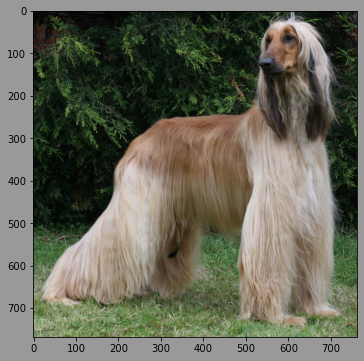


003.Airedale_terrier
torch.Size([3, 300, 400])


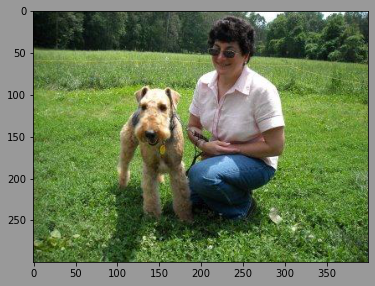


004.Akita
torch.Size([3, 393, 297])


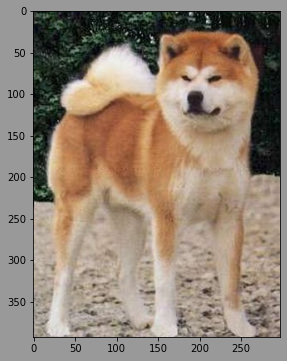


005.Alaskan_malamute
torch.Size([3, 285, 240])


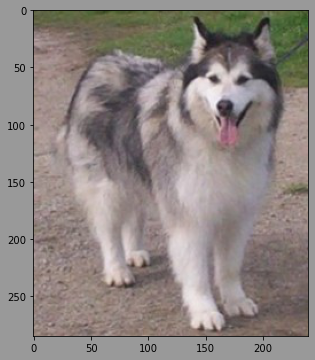

In [12]:
# Observation: Checking out some data sample images

PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True

#print ( os.listdir('.') )
DOGP0 = 'data/dogimages/'
DOGP11, DOGP12, DOGP13 = 'train/', 'valid/', 'test/'

dirp = DOGP0 + DOGP11
dogdirps = [ fdir for fdir in os.listdir(dirp) ]#  if  os.path.isfile ( os.path.join(dirp,f) ) ]
print ( dogdirps[:3] )
num_classes = len(dogdirps)

for dogdirp in dogdirps [:5]:
    for dogfp in os.listdir(dirp+dogdirp)[:1]:
        image = PIL.Image.open('{}{}/{}'.format(dirp,dogdirp,dogfp)).convert('RGB')

        imgtrf = trf.Compose ( [ trf.ToTensor () ] )
        imgtensor = imgtrf(image)[:3,:,:]

        img = imgtensor.numpy().squeeze()
        img = img.transpose (1,2,0)
        img = img.clip ( 0, 1 )

        print ()
        print ( dogdirp )
        print ( imgtensor.shape )
        fig = plt.figure ( figsize=(6,6), facecolor="#999999" )
        plt.imshow ( img )
        plt.show()


In [14]:
# Write data loaders for training, validation, and test sets specifying appropriate transforms, and batch_sizes

DOGP0 = 'data/dogimages/'
DOGP11, DOGP12, DOGP13 = 'train/', 'valid/', 'test/'
# using same means and stds as of VGG16's for now
NORM_MS = (0.485, 0.456, 0.406)
NORM_SS = (0.229, 0.224, 0.225)
IMG_SZ = (128,128)

trfp = DOGP0 + DOGP11
vdfp = DOGP0 + DOGP12
ttfp = DOGP0 + DOGP13

trtrf = transforms.Compose ( [
    transforms.Resize ( [ i+10 for i in IMG_SZ ] ),
    transforms.RandomRotation ( 30 ),
    transforms.RandomCrop ( IMG_SZ ),
    transforms.RandomHorizontalFlip ( p=0.5 ),
    transforms.RandomGrayscale ( p=0.17 ),
    transforms.ToTensor (),
    transforms.Normalize ( NORM_MS, NORM_SS ),
] )
tttrf = transforms.Compose ( [
    transforms.Resize ( [ i+10 for i in IMG_SZ ] ),
    transforms.CenterCrop ( IMG_SZ ),
    transforms.ToTensor (),
    transforms.Normalize ( NORM_MS, NORM_SS ),
] )

trset = datasets.ImageFolder ( trfp, transform=trtrf )
vdset = datasets.ImageFolder ( vdfp, transform=trtrf )
ttset = datasets.ImageFolder ( ttfp, transform=tttrf )

trldr = torch.utils.data.DataLoader ( trset, batch_size=128, shuffle=True, num_workers=0 )
vdldr = torch.utils.data.DataLoader ( vdset, batch_size=128, shuffle=True, num_workers=0 )
ttldr = torch.utils.data.DataLoader ( ttset, batch_size=128, shuffle=True, num_workers=0 )
loaders_scratch = { "train":trldr, "valid":vdldr, "test":ttldr }


In [15]:
## Model architecture

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d ( 3, 16, (5,5), stride=(1,1), padding=(2,2) )#, padding_mode='replicate' )
        self.pool1 = nn.MaxPool2d ( (2,2), (2,2) )
        self.conv2 = nn.Conv2d ( 16, 32, (5,5), stride=(1,1), padding=(2,2) )#, padding_mode='replicate' )
        self.pool2 = nn.MaxPool2d ( (4,4), (4,4) )
        self.conv3 = nn.Conv2d ( 32, 64, (5,5), stride=(1,1), padding=(2,2) )#, padding_mode='replicate' )
        self.pool3 = nn.MaxPool2d ( (4,4), (4,4) )
        self.fc1 = nn.Linear ( 1024, 512 )
        self.fc2 = nn.Linear ( 512, num_classes )
        #others
        self.relu = nn.ReLU()
        self.drpt = nn.Dropout ( p=0.25 )
        self.logsm = nn.LogSoftmax ( dim=1 )
        return
    def forward(self, A):
        ## Define forward behavior
        A = self.pool1 ( self.drpt ( self.relu ( self.conv1 ( A ) ) ) )
        A = self.pool2 ( self.drpt ( self.relu ( self.conv2 ( A ) ) ) )
        A = self.pool3 ( self.drpt ( self.relu ( self.conv3 ( A ) ) ) )
        A = self.drpt ( self.relu ( self.fc1 ( A.reshape(A.shape[0],-1) ) ) )
        A = self.logsm ( self.fc2 ( A ) )
        return A

# Copying the use_cuda definition here: check if CUDA is available
use_cuda = torch.cuda.is_available()

# instantiate the CNN
model_scratch = Net()
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()


In [19]:
## Train

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 

    for epoch in range(1, n_epochs+1):
        tini = time.time()
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            logps = model.forward ( data )
            loss = criterion ( logps, target )
            loss.backward()
            optimizer.step()
            # The above formula works without weights (equal batch sizes), but the last batch may be smaller, so:
            train_loss += loss * len(target)
            #if batch_idx%10==0:
            #    print ( batch_idx, time.time()-tini )
        train_loss = train_loss / len(trset)

        ######################
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            logps = model.forward ( data )
            loss = criterion ( logps, target )
            valid_loss += loss * len(target)
        valid_loss = valid_loss / len(vdset)

        # print training/validation statistics 
        print ( "Epoch: {:<4} ({:5.1f} s)  {:36}{:>12.6f}{:>12.6f}".
               format ( epoch, time.time()-tini, "Training and Validation Losses:", train_loss, valid_loss ) )

        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            valid_loss_min = valid_loss
            torch.save ( model.state_dict(), save_path )

    # return trained model
    return model


# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))


Epoch: 1    ( 97.5 s)  Training and Validation Losses:         4.698431    4.669331
Epoch: 2    (105.7 s)  Training and Validation Losses:         4.494727    4.589198
Epoch: 3    (101.9 s)  Training and Validation Losses:         4.342621    4.463847
Epoch: 4    ( 94.8 s)  Training and Validation Losses:         4.242610    4.409170
Epoch: 5    ( 93.6 s)  Training and Validation Losses:         4.117160    4.358198
Epoch: 6    ( 94.6 s)  Training and Validation Losses:         4.053757    4.273365
Epoch: 7    ( 92.7 s)  Training and Validation Losses:         3.947197    4.248191
Epoch: 8    ( 93.7 s)  Training and Validation Losses:         3.850037    4.163991
Epoch: 9    ( 95.9 s)  Training and Validation Losses:         3.794423    4.105185
Epoch: 10   ( 92.9 s)  Training and Validation Losses:         3.704292    4.095688
Epoch: 11   ( 93.1 s)  Training and Validation Losses:         3.617649    4.092824
Epoch: 12   ( 93.2 s)  Training and Validation Losses:         3.566433    4

Epoch: 99   (111.7 s)  Training and Validation Losses:         1.387766    3.762101
Epoch: 100  (113.6 s)  Training and Validation Losses:         1.433339    3.712255


<All keys matched successfully>

In [20]:

def test(loaders, model, criterion, use_cuda):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % ( 100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.510404


Test Accuracy: 20% (175/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [115]:
## TODO: Specify data loaders

# I'm indeed using the same data loaders, reinitialized hereby:
trldr = torch.utils.data.DataLoader ( trset, batch_size=128, shuffle=True, num_workers=0 )
vdldr = torch.utils.data.DataLoader ( vdset, batch_size=128, shuffle=True, num_workers=0 )
ttldr = torch.utils.data.DataLoader ( ttset, batch_size=128, shuffle=True, num_workers=0 )
loaders_transfer = { "train":trldr, "valid":vdldr, "test":ttldr }


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [116]:

## TODO: Specify model architecture 
class ModelTransfer ( nn.Module ):
    def __init__ ( self ):
        super ( ModelTransfer, self ).__init__ ()
        #self.fc1 = nn.Linear ( 25088, 4096 )
        self.fc2 = nn.Linear ( 4096, 768 )
        self.fc3 = nn.Linear ( 768, num_classes )
        # others:
        self.drpt = nn.Dropout ( p=0.3 )
        self.relu = nn.ReLU ()
        self.logsf = nn.LogSoftmax ( dim=1 )
        return
    def forward ( self, A ):
        #A = self.drpt ( self.relu ( self.fc1 ( A.reshape(A.shape[0],-1) ) ) )
        A = self.drpt ( self.relu ( self.fc2 ( A.reshape(A.shape[0],-1) ) ) )
        #A = self.drpt ( self.relu ( self.fc2 ( A ) ) )
        A = self.logsf ( self.fc3 ( A ) )
        return A

model_transfer = models.vgg16 ( pretrained=True )
for param in model_transfer.features.parameters():
    param.requires_grad = False
model_transfer.classifier[6] = ModelTransfer()

if use_cuda:
    model_transfer = model_transfer.cuda()


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
- The VGG16 model's "features" layers has already learnt to collect diverse high-level features at different spatial scales very well, thanks to its many-parametered conv layers, many various downscaling max pool layers, and it's former classification task of distibguishing across 1000 classes. Here, the features section of VGG16 is capped with my 2 fully connected layers keeping the first of the VGG16 FC layers but not freezing it, so effectively 5 FC layers of { 25088, 4096, 4096, 768, 133 } nodes, respectively, are available for retraining given the 133-class distinction task. I wished to give plenty of degrees of freedom still given enough time, also thinking that the FC layers I kept but left unfrozen had adequate initialized weights for efficient retraining. Some of these assumptions may be false, but practically the training worked very well again exceeding the required accuracy metric. I did after an immature initial attempt reduce the learning rate.
- Again, each subsequent layer's input dimension shall match its prior layer's output's. 5 FC layers could be reduced, but with efficient initial success, I haven't tried reducing the complexity / degrees of freedom of the system. 0.73 accuracy given 133 classes (<1% correct by random chance) is absolutely very impressive! I've used a relu non-linear function each layer's output for confinement and as activation function. Given the multitude of nodes, I've used regularization with Dropout layers before every FC layer after the first. Finally, effectively a softmax function would determine the probability for each class, and the loss would effectively be calculated based on the cross-entropy. I could have trained for longer.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [117]:

criterion_transfer = nn.NLLLoss()
optimizer_transfer = optim.Adam ( model_transfer.classifier.parameters(), lr=0.0003 )


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [118]:

# train the model
model_transfer = train ( 20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer,
                        use_cuda, 'model_transfer.pt' )
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict ( torch.load('model_transfer.pt') )


Epoch: 1    (335.8 s)  Training and Validation Losses:         3.397468    2.243336
Epoch: 2    (330.5 s)  Training and Validation Losses:         2.293066    1.954885
Epoch: 3    (328.0 s)  Training and Validation Losses:         1.986244    1.732762
Epoch: 4    (327.1 s)  Training and Validation Losses:         1.837333    1.673722
Epoch: 5    (333.2 s)  Training and Validation Losses:         1.700176    1.563804
Epoch: 6    (329.4 s)  Training and Validation Losses:         1.641177    1.543561
Epoch: 7    (326.0 s)  Training and Validation Losses:         1.590306    1.598563
Epoch: 8    (325.4 s)  Training and Validation Losses:         1.511701    1.428951
Epoch: 9    (325.3 s)  Training and Validation Losses:         1.472124    1.461195
Epoch: 10   (325.1 s)  Training and Validation Losses:         1.437163    1.398659
Epoch: 11   (325.0 s)  Training and Validation Losses:         1.330524    1.424366
Epoch: 12   (325.5 s)  Training and Validation Losses:         1.321396    1

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [119]:

test ( loaders_transfer, model_transfer, criterion_transfer, use_cuda )


Test Loss: 0.985972


Test Accuracy: 73% (618/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [188]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
trdir = 'data/dogimages/train/'
trdirs = [ dirp for dirp in os.listdir(trdir)  if not os.path.isfile ( os.path.join(trdir,dirp) ) ]
#class_names = [ item[4:].replace("_", " ") for item in data_transfer['train'].classes ]
CLASS_NAMES = [ item[4:].replace("_", " ") for item in trdirs ]

def predict_breed_transfer ( img_path ):
    tttrf = transforms.Compose ( [
        transforms.Resize ( [ i+10 for i in IMG_SZ ] ),
        transforms.CenterCrop ( IMG_SZ ),
        transforms.ToTensor (),
        transforms.Normalize ( NORM_MS, NORM_SS ),
    ] )
    img = Image.open ( img_path ).convert ( 'RGB' )
    imgtensor = tttrf ( img ) [:3,:,:]
    imgtensor = imgtensor.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    #if use_cuda:
    #    imgtensor = imgtensor.cuda()  #assumes that you're using GPU

    # load the image and return the predicted breed
    logps = model_transfer.forward ( imgtensor )
    ps = torch.exp ( logps )
    # some limited mutt support:
    topps, topis = ps.topk ( 5, dim=1 )
    topps, topis = torch.squeeze(topps), torch.squeeze(topis)
    #print ( topps, topis )
    # taking care of mutt probs
    clsidx = [topis[0]]   # include 1st item, whatever the p, since aprior we've confirmed hum/dog presence
    for rnk,(p,clsi) in enumerate(zip(topps,topis)):
        if p > 0.9:
            break
        if rnk>0 and p>0.2 and p>=0.33*topps[i-1]:
            clsidx.append ( clsi )
        else: break
    dogidx = [ CLASS_NAMES[i] for i in clsidx ]
    return { "dogidx":dogidx, "topps":topps, "topis":topis }


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [371]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

IDSTR_D = { "dog":"dog", "hum":"human face", "ugo":"UGO" }
CLR_BS = { 'dog':"#aa4411", 'hum':"#cc77aa", 'ugo':"#888888" }
DEWR = 0.3   # Ratio of distance btw eyes to image width of the dog ears image (dogears2.png)
DXR, DYR = 0.51, 0.45   # ratio of dog image, mid-eyes-point to top-left corner of its image

def run_app ( img_path ):
    ## handle cases for a human face, dog, and neither

    idstr = 'ugo'   # unidentified general object
    epistr = ""
    fc_detect = face_detector ( img_path )
    # priority is given to dog detection since this is mainly a dog detection app, even attributes dog to people!
    dog_bool = dog_detector ( img_path )
    fac_bool = fc_detect['face_bool']
    ugo_bool = not ( dog_bool or fac_bool )

    if dog_bool:
        idstr = 'dog'
    elif fac_bool:
        idstr = 'hum'
        epistr = " -esque"
    predbreed_out = predict_breed_transfer ( img_path )
    dogids = predbreed_out['dogidx']
    topps = predbreed_out['topps']
    topis = predbreed_out['topis']
    nk = len(topis)
    statement = "Hello {},\n{}{} !!".format ( IDSTR_D[idstr] , " -- ".join(dogids) , epistr )
    if ugo_bool:
        statement = "Hello unidentified general object!"


    # Plot
    clrs = nk * [ CLR_BS[idstr] ]
    edgclrs = clrs.copy()
    finimgsz = (12,6)
    curimg = PIL.Image.open ( img_path ).convert ( 'RGB' )
    dogears = PIL.Image.open ( 'data/dogears2.png' ).convert ( 'RGBA' )
    w1,h1 = dogears.size
    fig = plt.figure ( figsize=finimgsz, facecolor="#aaaaaa" )
    figgrid = matplotlib.gridspec.GridSpec ( ncols=3, nrows=1, figure=fig )
    ax1,ax2 = fig.add_subplot(figgrid[0,:2]), fig.add_subplot(figgrid[0,2])

    img0 = ax1.imshow ( curimg )
    bx1,bx2,by1,by2 = img0.get_extent()
    ax1.set_title ( statement, fontsize=2*finimgsz[1], y=1. )
    eyectrs_d = fc_detect['fceyes_d']
    #print ( * eyectrs_d.items(), sep="\n" )
    for fc in eyectrs_d.keys():
        eyes = eyectrs_d[fc]
        #print ( eyes )
        if not eyes:
            continue
        x,y = (eyes[1][0]+eyes[0][0])/2., (eyes[1][1]+eyes[0][1])/2.
        dx,dy = eyes[1][0]-eyes[0][0], eyes[1][1]-eyes[0][1]
        eydist = np.sqrt ( dy**2 + dx**2 )   # distance between the eyes
        angl = np.arctan ( dy/dx )
        bw,bh = bx2-bx1, (bx2-bx1)*h1/w1
        rscale = eydist/(bw*DEWR)   # ratio of dimensions between dog ears image and base image
        img1 = ax1.imshow ( dogears, interpolation='none', extent=[0,bw,bh,0], clip_on=True, alpha=1. )
        im_trf = ( mtrf.Affine2D ().
                      scale ( rscale ).
                      translate ( x-rscale*bw*DXR,y-rscale*bh*DYR ).
                      rotate_around ( x, y, angl )
                  + ax1.transData )
        img1.set_transform ( im_trf )

    ax1.set_xlim(bx1,bx2)
    ax1.set_ylim(by1,by2)
    ax1.set_xticks ( [] )
    ax1.set_yticks ( [] )
    ax2.set_facecolor ( "#222222" )
    ax2.bar ( list(range(nk)), topps.cpu().detach().numpy(), color=clrs, edgecolor=edgclrs )
    ax2.set_ylim ( bottom=0., top=1. )
    ax2.set_xticks ( list(range(nk)) )
    ax2.set_xticklabels ( [ CLASS_NAMES[i].upper() for i in topis ], rotation=90, fontsize=1.6*finimgsz[1] )
    ax2.set_ylabel ( "probability", fontsize=1.6*finimgsz[1] )
    #ax2.set_yticks ( [] )
    plt.show()

    return statement


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
- For augmentation I would have liked to use even more trasnformations but thought I'd have to then have more epochs. E.g. perspective for such images sounds reasonable. There's a combined resize-randcrop I'd like to experiment with too
- Grid search across more dimensions, e.g. learning rate, more FC layers, different conv/pool layer arrnagments, etc.. I was satisfied and stopped with first attempt getting 20% accuracy n model_scratch, so can explore more.
- I wonder if num images per dog class are distributed evenly across the 133 classes, according to the world dog population, or otherwise. This can affect testing statistics, just to consider. Maybe it likes poodles.
- I'm not sure how it can be done robustly, to output a statement about all elements if there are dogs AND people, or multiple dogs.
- Some proper error handling and tests
- incorporating better human/dog presence models
- I added the capability of adding dog ears to "people" in the right places, but the ear types are not appropriate and generally of the hanging kind. One could download sets of ear images of the 133 types to match them accordingly.

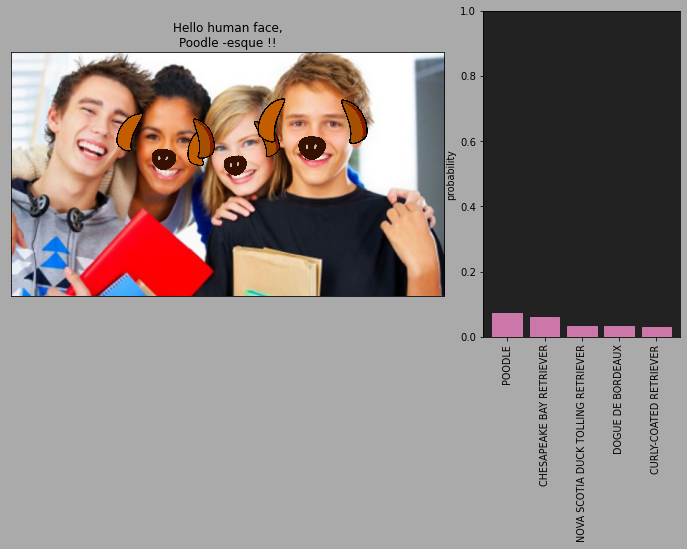

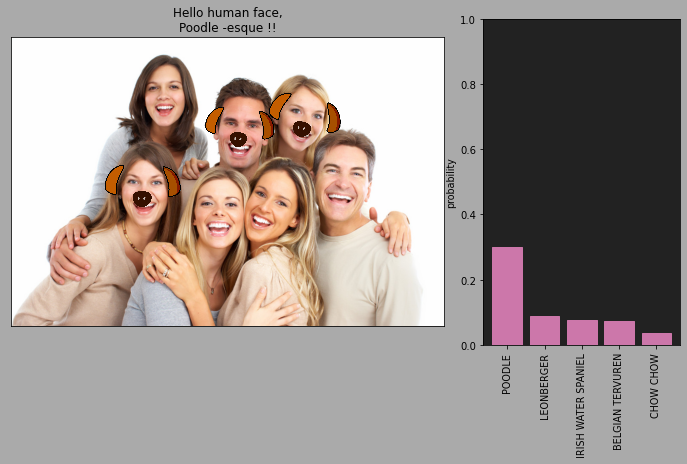

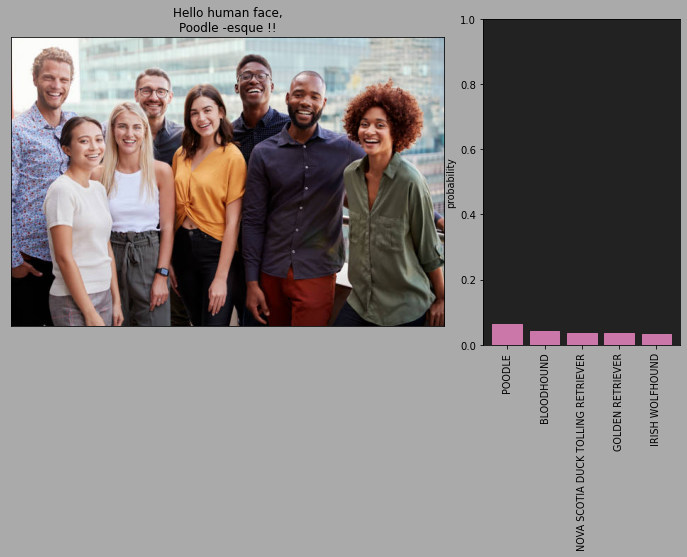

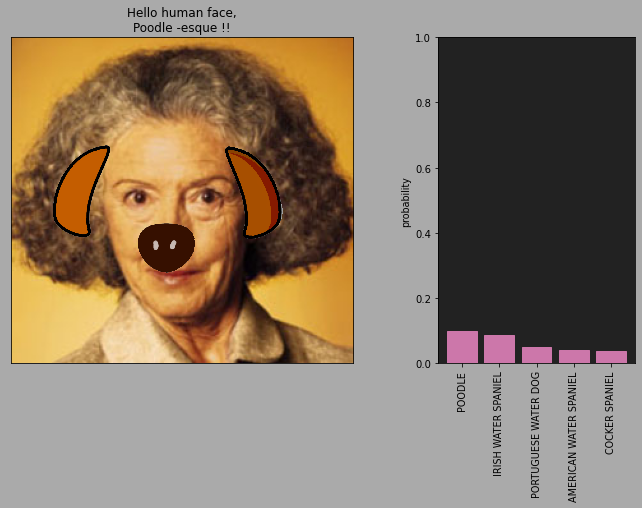

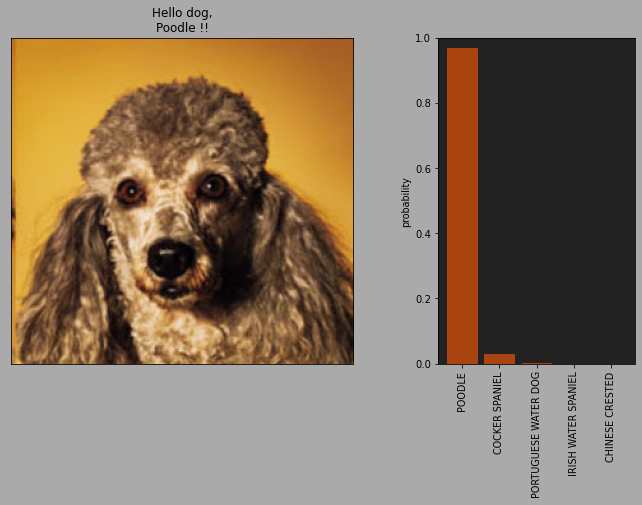

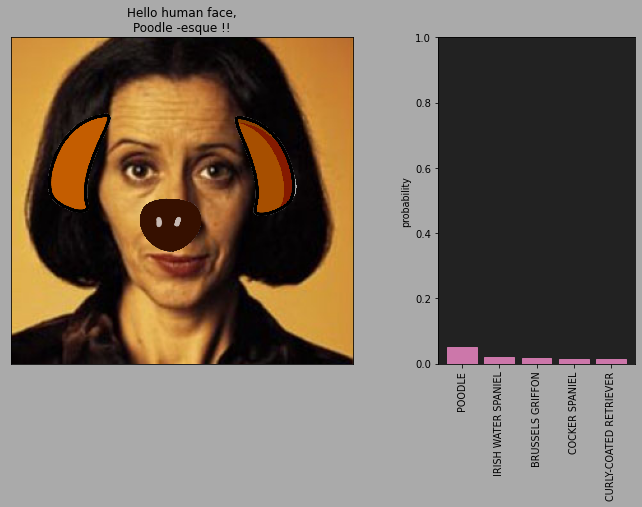

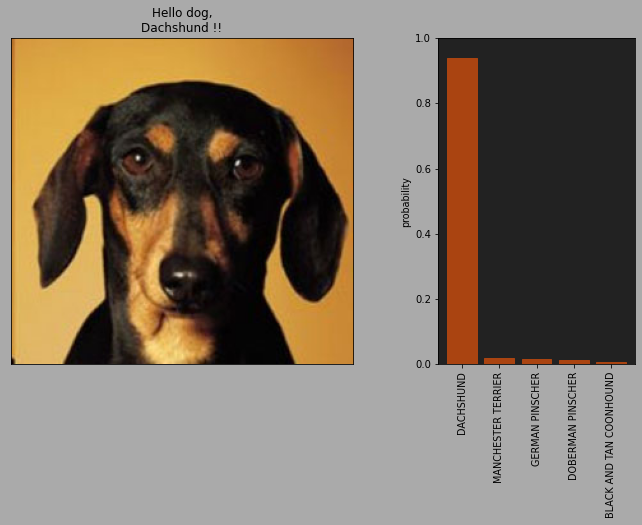

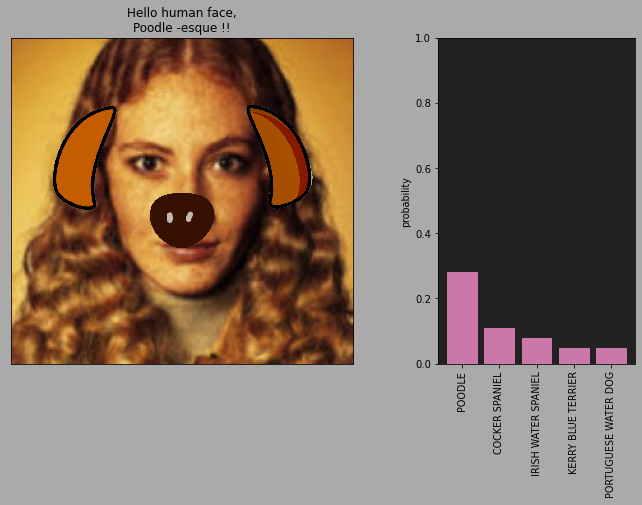

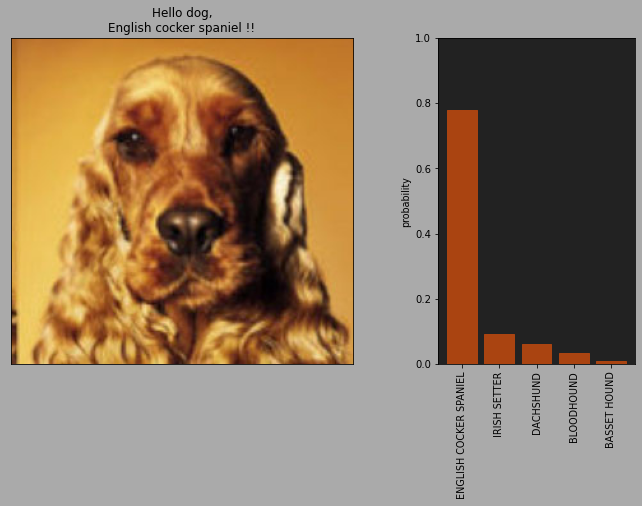

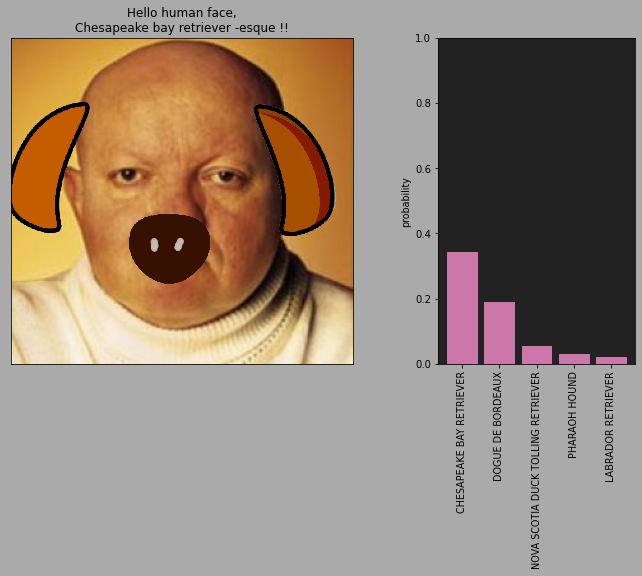

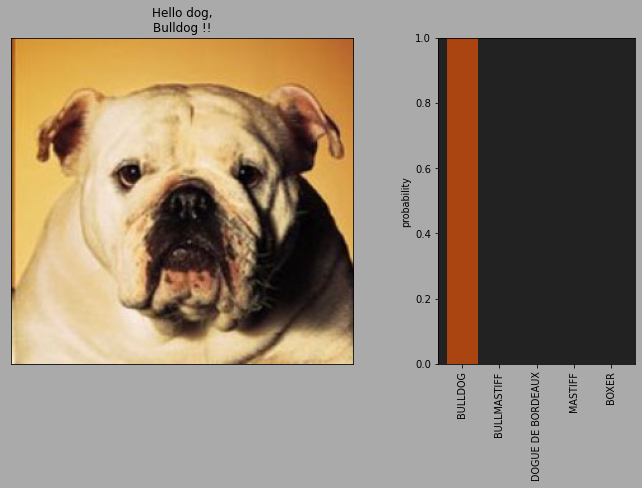

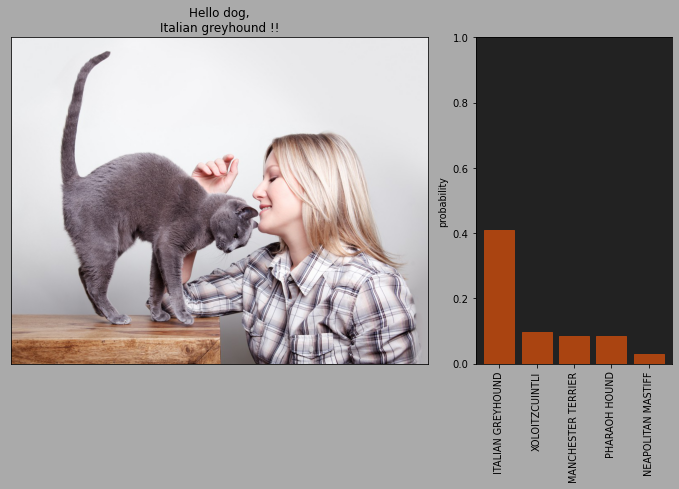

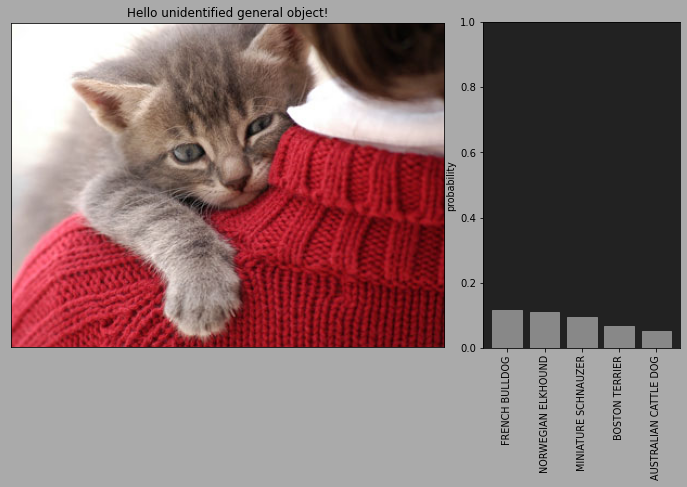

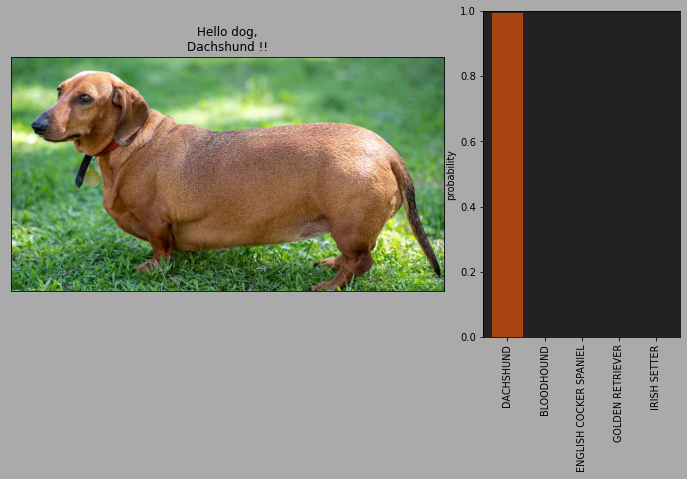

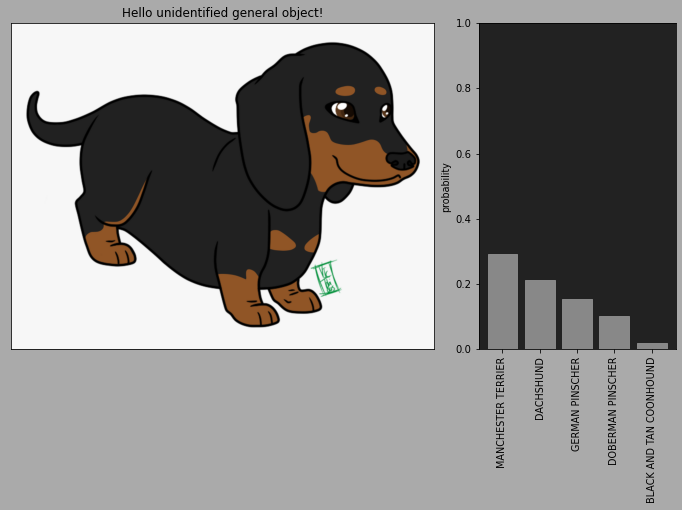

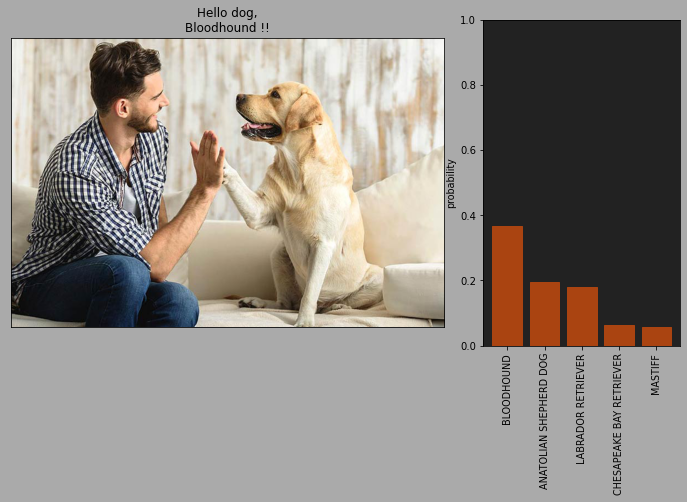

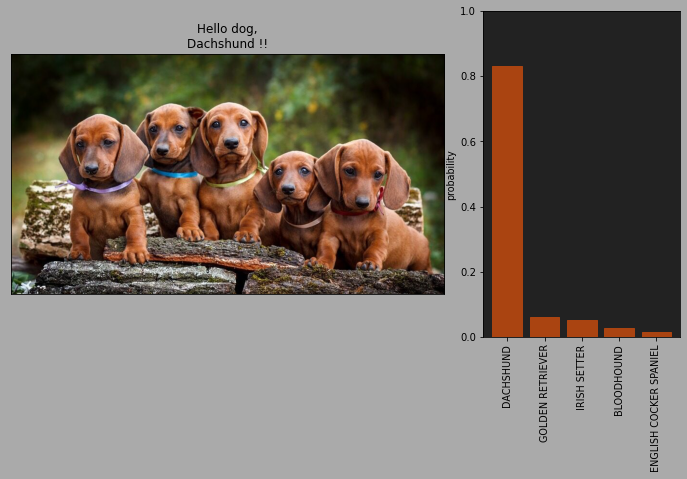

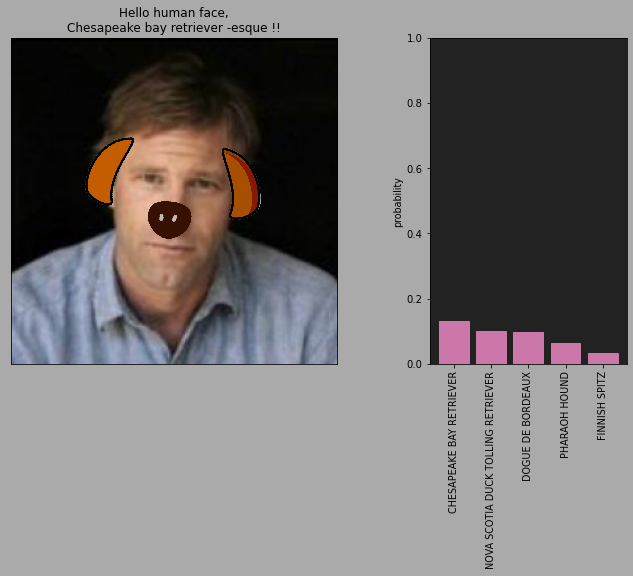

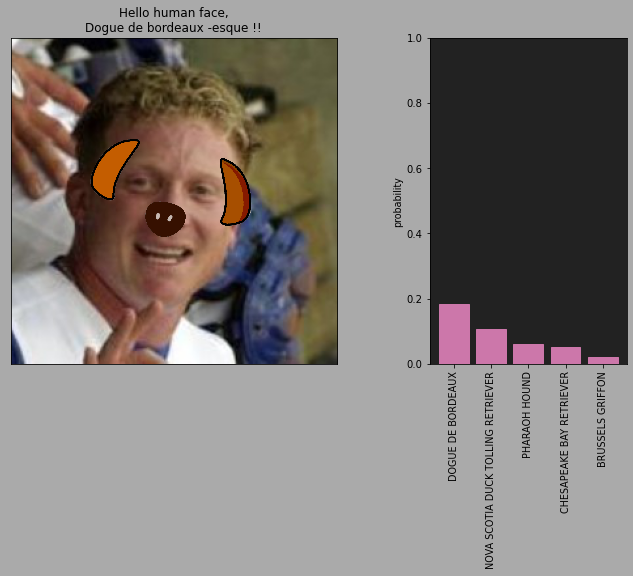

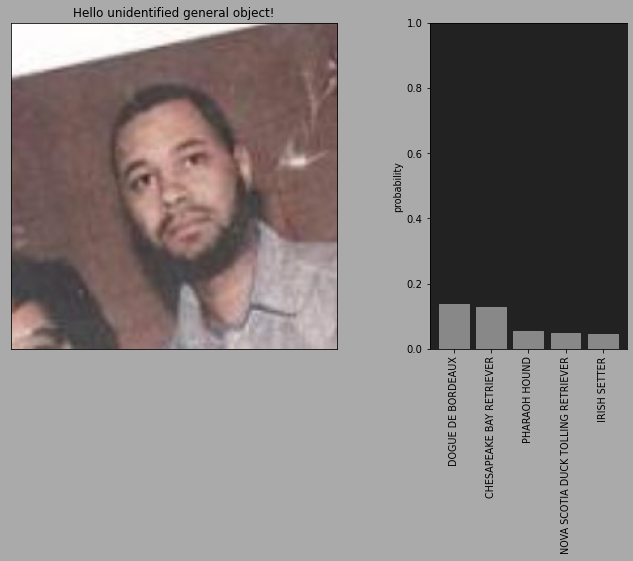

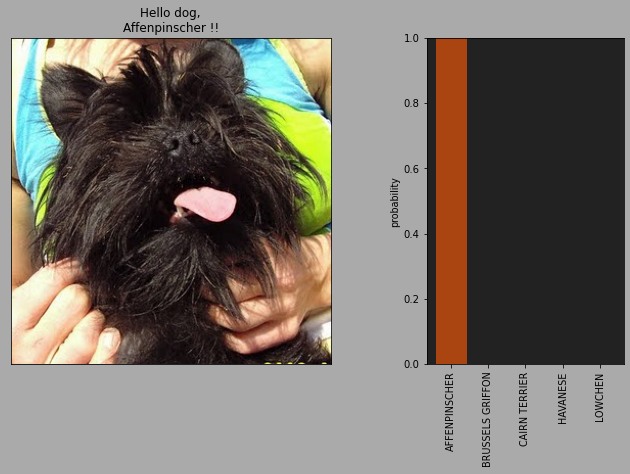

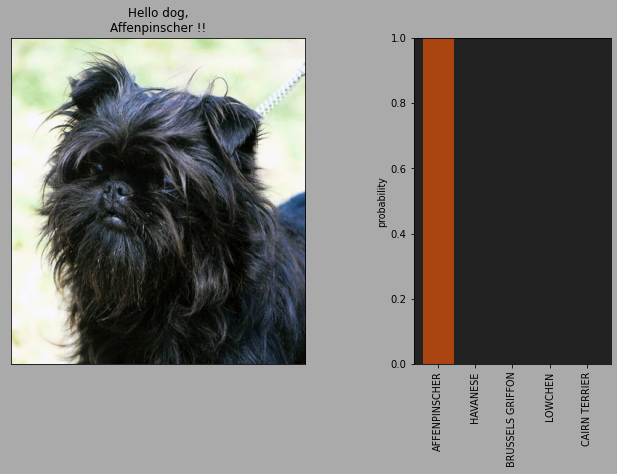

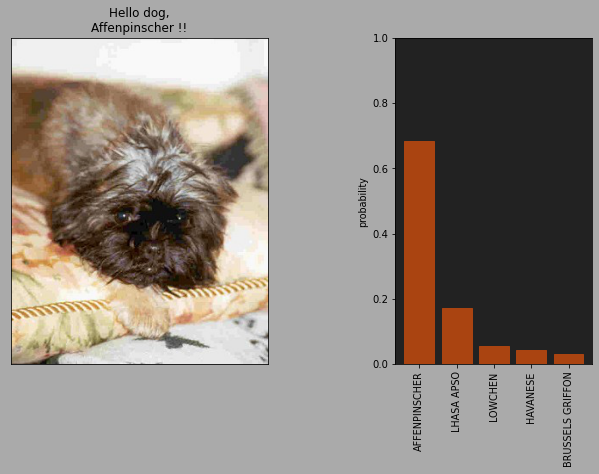

In [372]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

custdir = 'data/custom_test/'
custfps = [ "{}{}".format(custdir,f) for f in os.listdir(custdir)  if  os.path.isfile ( os.path.join(custdir,f) ) ]
## suggested code, below
for file in np.hstack ( ( custfps, human_files[:3], dog_files[:3] ) ):
    run_app ( file )
    #print()


In [376]:

""" Faraz comments about submission:
Submit:
- this notebook
- html/pdf of this notebook
- any additional image used (dogears2.png, custom_test folder)
[have answered questions, all output printed]

Optional Suggested Done:
- Augmenting the training and/or validation set might help improve model performance
- augment w dog ears if human:
    Used cascading eye detector from OpenCV2 and used the relative eyes position (if 2 within each face boundary)
    to position the dog ears
- add functionality for dog mutts:
    Added the functionality but not caught any in tests. It would output a blend dog iff p0 < 0.9 and
    p_i/p_i-1 > 0.7 for subsequent p_is

Optional Suggested not done:
- Step 1 end: Optional other models for human face detection; report metrics
- Step 2 end: Optional other models for dog detection; report metrics
- make a web app using Flask for the app
These would constitute substantial projects on their own, so I put them aside. I tried to find a common model for both
    dog and human detection
But I came to understand that ImageNet-trained models don't classify human unless transfer-learned on to.
"""
print ()
print ( torch.__version__ )
#print ( VGG16 )

"""
# Grader comments:

General:
- Do look at how to deploy these models on the edge like a browser (using tf.js) or on iot/mobile devices using tflite.
- use descriptive general consistent var names, e.g. { trtrf, tttrf, imgfp } -> { train_trans, tst_trans, img_fpath }
VGG16 inference:
- can use   "with torch.no_grad():" clause since we're only evaluating and (also model.eval()?) don't need grad-memory
- training data distribution should cover all classes it covers, not necessarily reflectthe real-world distribution.
    That's the job of the validation and test data sets
Data:
- don't shuffle validation and test sets; only need to shuffle trainig set
- could check output of augmented data to make sure it's still human-sensible
- could use SMOTE to reduce data imbalance
- to reuse the dataloader for the 2nd model, can just use trldr = trldr.copy()   (no need to reinitialize w func, ...)
CNN scratch model:
- can visualize each layer and filters and their learning shapes, makes the layer choices more intuitive:
    https://cs231n.github.io/understanding-cnn/
- structure: use batchnorm since class imbalance
- could vary optim params, use a learning rate scheduler, early stopping
- during training can plot J vs iteration step to check for . Here, it's overfit
- can discuss how you can improve your accuracy by introducing weights initialization and more sophisticated network in your scratch model to improve its accuracy.
Transfer-learnt model:
You can use high learning rate here.
- Ideally, you should train for 10 epochs max in a pre-trained model because the possibility of overfitting is more. So you can use high learning rate and close it early.
[didn't agree w the one above until I read the one below. I'd used lr 0.001 w my present structure w 0.6 acc, and then had 0.73 after reducing lr to 0.0003]
- You can push accuracy here till 86-87% here with some tweaks in learning rate and also adding an extra fc layer in the end if you want.
- can work more on fine-tuning transfer-learning models, as practically industrially these are mainly used
Final put-togetheralgorithm:
- the ugo conditional for the statement variable could have been put inside with the condtional for the other dog/hum cases
- maybe overfit on poodle since most human faces get poodle among dog breeds
- for group human photos check and indicate which face was used to predict the dog breed [(I guess visualizing activations)]

"""



1.7.1
